# Satellite Use Classification | Unsupervised Learning Approach

## Problem Overview

This project focuses on classifying the purpose of satellites using data provided by the UCS organization. The goal is to explore and test unsupervised learning approaches, K-Means and DBSCAN, to predict a satellite's purpose.

The project aims to identify the most influential features for predicting a satellite's purpose. Additionally, it seeks to address issues of biased data by implementing strategies to mitigate bias in the classification process. This research not only enhances our understanding of satellite usage but also contributes to the development of more accurate and unbiased classification models.

## About the dataset

The dataset I'll be using for this project was compiled by the Union of Concerned Scientists (UCS) from several sources. The dataset contains information about various satellites that are currently or have been in orbit.

The dataset is available here: https://www.ucsusa.org/resources/satellite-database

# Exploratory Data Analysis (EDA) & Data Preparation

In this section we'll be performing exploratory data analysis on the data we're going work with. Preliminary data cleaning has already been completed in the `data_cleaning` notebook. However there are a few additional steps we'll need to take to prepare the data specifically to enter the supervised model we'll be building later on.

In the `supervised_satellite_classification` notebook we did some preliminary EDA and found the data to be biased towards Communications satellites, as they made up more than half of the data set. In this section, we'll explore ways to mitigate that bias.

As a summary here are the steps we'll take in this section:
- Explore bias mitigation techniques
- Visualize the data available for each attribute
- Set up label encodings for text-based data for entering the model

## Loading the Data
Here we load the clean data output from the `data_cleaning` notebook.

In [1]:
import pandas as pd

sat_df = pd.read_csv('satellite_db_clean.csv')
sat_df.head()

,Country of Operator/Owner,Users,Purpose,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Eccentricity,Inclination (degrees),Period (minutes),Launch Mass (kg.),Launch Site,Launch Vehicle,Date of Launch,Purpose_subset
0,USA,COMMERCIAL,EARTH OBSERVATION,NON-POLAR INCLINED,0.0,566.0,576.0,0.001510,36.90,96.08,22.0,SATISH DHAWAN SPACE CENTER,PSLV,2019-12-11,EARTH OBSERVATION
1,UNITED KINGDOM,COMMERCIAL,EARTH OBSERVATION,SUN-SYNCHRONOUS,0.0,637.0,654.0,0.001510,98.00,95.00,4.0,CAPE CANAVERAL,FALCON 9,2023-01-03,EARTH OBSERVATION
2,FINLAND,CIVIL,TECHNOLOGY DEVELOPMENT,SUN-SYNCHRONOUS,0.0,497.0,517.0,0.001450,97.45,94.70,4.5,SATISH DHAWAN SPACE CENTER,PSLV,2017-06-23,TECHNOLOGY DEVELOPMENT
3,DENMARK,CIVIL,EARTH OBSERVATION,SUN-SYNCHRONOUS,0.0,442.0,687.0,0.001510,98.20,95.90,1.0,GUIANA SPACE CENTER,SOYUZ-2.1A,2016-04-25,EARTH OBSERVATION
4,MULTINATIONAL,COMMERCIAL,COMMUNICATIONS,EQUATORIAL,75.0,35778.0,35793.0,0.000178,0.08,1436.03,6330.0,GUIANA SPACE CENTER,ARIANE 5 ECA,2014-02-06,COMMUNICATIONS


In [2]:
print(f"This dataset has {sat_df.shape[0]} entries and {sat_df.shape[1]} attributes.")
print(f"Available Attributes:\n\n{sat_df.dtypes}")

This dataset has 7201 entries and 15 attributes.
Available Attributes:

Country of Operator/Owner      object
Users                          object
Purpose                        object
Type of Orbit                  object
Longitude of GEO (degrees)    float64
Perigee (km)                  float64
Apogee (km)                   float64
Eccentricity                  float64
Inclination (degrees)         float64
Period (minutes)              float64
Launch Mass (kg.)             float64
Launch Site                    object
Launch Vehicle                 object
Date of Launch                 object
Purpose_subset                 object
dtype: object


In [3]:
# Set date to correct type
sat_df['Date of Launch'] = pd.to_datetime(sat_df['Date of Launch'])

## Helper Functions for Data Visualization

In [4]:
from re import U
import pandas as pd
import matplotlib.pyplot as plt
# Helpers
def plot_top_n_histogram(df, column_name, n):
    # Get the unique values and their counts
    value_counts = df[column_name].value_counts()

    # If there are more than n unique values, take the top n
    if len(value_counts) > n:
        value_counts = value_counts.head(n)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    # value_counts.plot(kind='hist', density=True)
    (value_counts / len(df)).plot(kind='bar')
    plt.xlabel(f'{column_name} Values')
    plt.ylabel('Density')
    plt.title(f'Top {n} values in {column_name}')
    plt.xticks(rotation=90)
    plt.show()

def box_plot(df: pd.DataFrame, column: str):
  boxplot = df.boxplot(column=column, showfliers=False)
  plt.ylabel(f'{column} Value')
  plt.title(f'Box Plot of {column} Values')
  plt.show()

def plot_dates(df: pd.DataFrame, column: str):
  launches_per_year = df.groupby(df[column].dt.year).size()
  launches_per_year.plot(kind='bar', xlabel='Year', ylabel='Number of Launches', title='Launches by Year')
  plt.show()

def column_overview(df: pd.DataFrame, column: str, show_plot: bool = False, n:int = 50) -> None:
    print(f"Column: {column}")
    print(f"Type: {df[column].dtype}")
    unique_values = df[column].unique()
    print(f"Found {len(unique_values)} unique values")
    if show_plot:
        if df[column].dtype == 'datetime64[ns]':
          plot_dates(df, column)
        elif df[column].dtype == 'float64':
          box_plot(df, column)
        else:
          num_values = len(df[column].unique())
          if num_values < n:
            n = num_values
          plot_top_n_histogram(df, column, n=n)
    else:
      try:
        unique_values = sorted(df[column].unique().tolist())
        print(unique_values)
      except Exception:
        print(unique_values)


## Modifying Target Variable

During model evaluation, we must loop through permutations of labels to map the predicted labels to the real label values, if we have too many classes to work with permuting through these will be too computationally expensive, so to reduce the number of permutations, we can modify the target classifications before we resample. If we look at the value counts for our target below, we see most have fewer than 100 entries. We can remove those entries as they are not going to be good candidates for resampling.

In [5]:
sat_df['Purpose'].value_counts()

COMMUNICATIONS                                    5469
EARTH OBSERVATION                                 1083
TECHNOLOGY DEVELOPMENT                             291
GLOBAL POSITIONING/NAVIGATION                      118
SPACE SCIENCE                                       73
TECHNOLOGY DEMONSTRATION                            54
EARTH SCIENCE                                       26
SURVEILLANCE                                        18
NAVIGATION/REGIONAL POSITIONING                     13
EARTH OBSERVATION/NAVIGATION                         9
SPACE OBSERVATION                                    8
METEOROLOGICAL                                       6
EARTH OBSERVATION/TECHNOLOGY DEVELOPMENT             6
COMMUNICATIONS/MARITIME TRACKING                     5
COMMUNICATIONS/TECHNOLOGY DEVELOPMENT                4
EDUCATIONAL/TECHNOLOGY DEVELOPMENT                   2
MISSION EXTENSION TECHNOLOGY                         2
EARTH OBSERVATION/EARTH SCIENCE                      2
COMMUNICAT

Column: Purpose
Type: object
Found 4 unique values


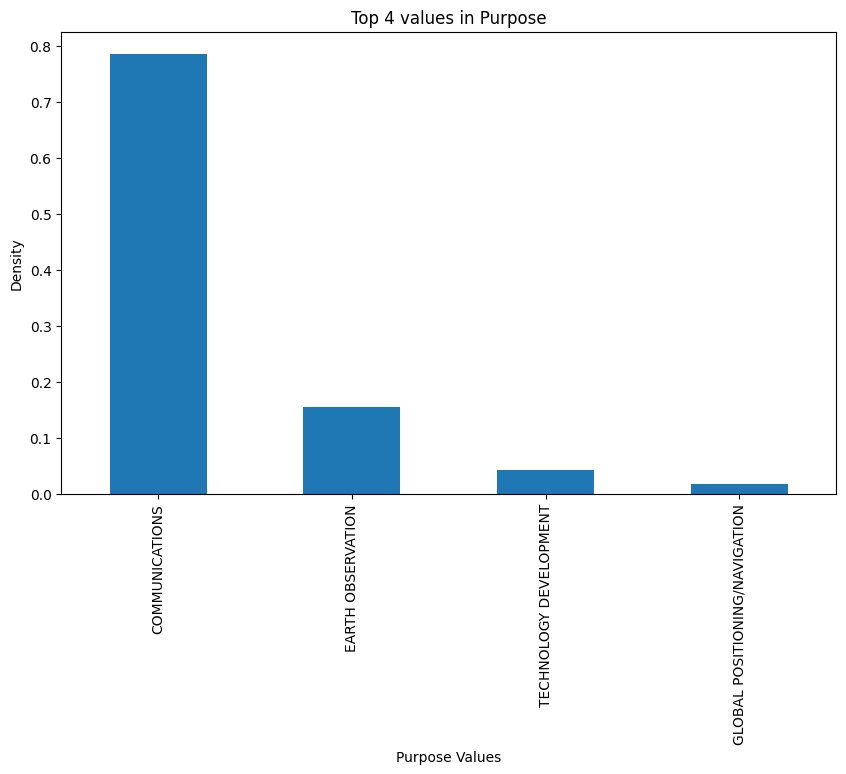

In [6]:
value_counts = sat_df['Purpose'].value_counts()
valid_purposes = value_counts[value_counts >= 100].index
filtered_df = sat_df[sat_df['Purpose'].isin(valid_purposes)]
sat_df = filtered_df

column_overview(sat_df, 'Purpose', show_plot=True)

## Handling Imbalanced Data

As we can see from the plot below, our classifications are imbalanced. The majority of satellites in our dataset are Communications satellites. In the supervised appraoch I tried undersampling the Communications entries. However the classifications were still fairly imbalanced. In this section we're going to explore Random Over/Under sampling. For reference, [this](https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de) blog post was helpful in explaining how to use these techniques in python.

In [7]:
sat_df['Purpose'].value_counts()

COMMUNICATIONS                   5469
EARTH OBSERVATION                1083
TECHNOLOGY DEVELOPMENT            291
GLOBAL POSITIONING/NAVIGATION     118
Name: Purpose, dtype: int64

In [8]:
from sklearn.utils import resample

comm_class = sat_df[(sat_df['Purpose'] == 'COMMUNICATIONS')]
eo_class = sat_df[(sat_df['Purpose'] == 'EARTH OBSERVATION')]
td_class = sat_df[(sat_df['Purpose'] == 'TECHNOLOGY DEVELOPMENT')]
gps_class = sat_df[(sat_df['Purpose'] == 'GLOBAL POSITIONING/NAVIGATION')]

samples = 500

comm_downsampled = resample(comm_class, replace=False, n_samples=samples, random_state=55)
eo_downsampled = resample(eo_class, replace=False, n_samples=samples, random_state=55)
td_upsampled = resample(td_class, replace=True, n_samples=samples, random_state=55)
gps_upsampled = resample(gps_class, replace=True, n_samples=samples, random_state=55)


# Combine the downsampled majority and upsampled minority
balanced_data = pd.concat([comm_downsampled, eo_downsampled, td_upsampled, gps_upsampled])
print(balanced_data.shape)

# sat_df = balanced_data

(2000, 15)


Column: Purpose
Type: object
Found 4 unique values


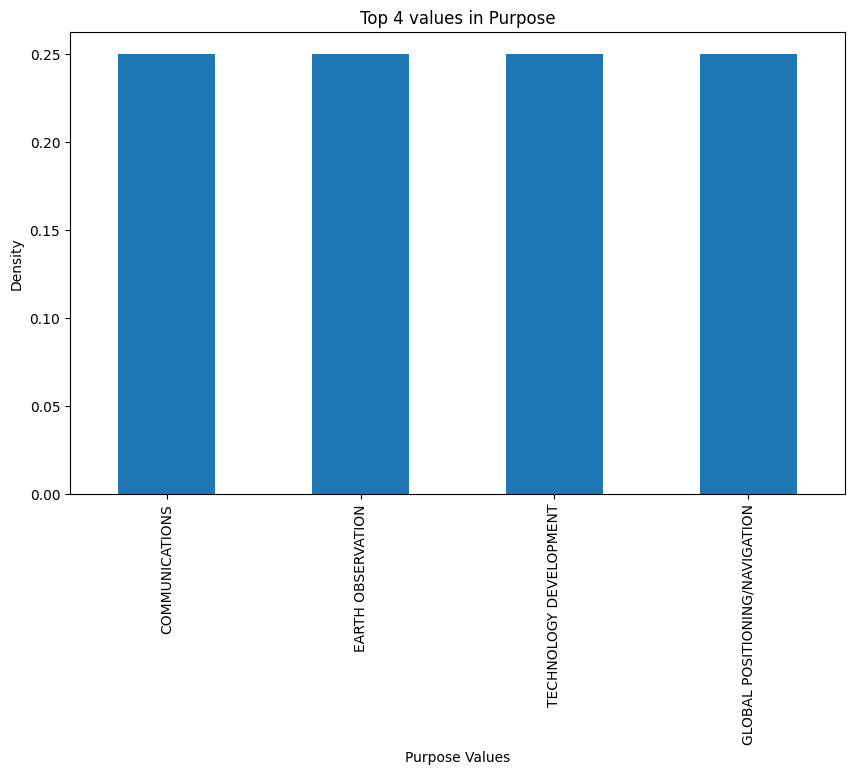

In [9]:
column_overview(balanced_data, "Purpose", show_plot=True)

## Exploratory Data Analysis - Balanced Data

In the `supervised_satellite_classification` notebook, we did some initial analysis on the original imbalanced data. In this section I'll generate a handful of plots to get an idea for the balanced data and for how the data are distributed.

Column: Country of Operator/Owner
Type: object
Found 73 unique values


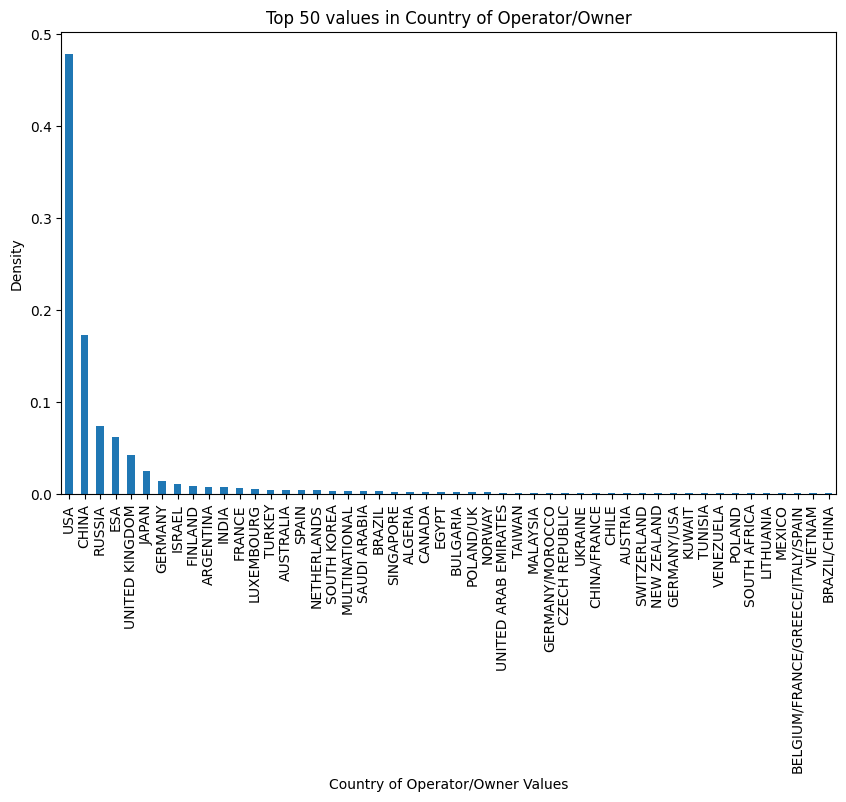

Column: Users
Type: object
Found 10 unique values


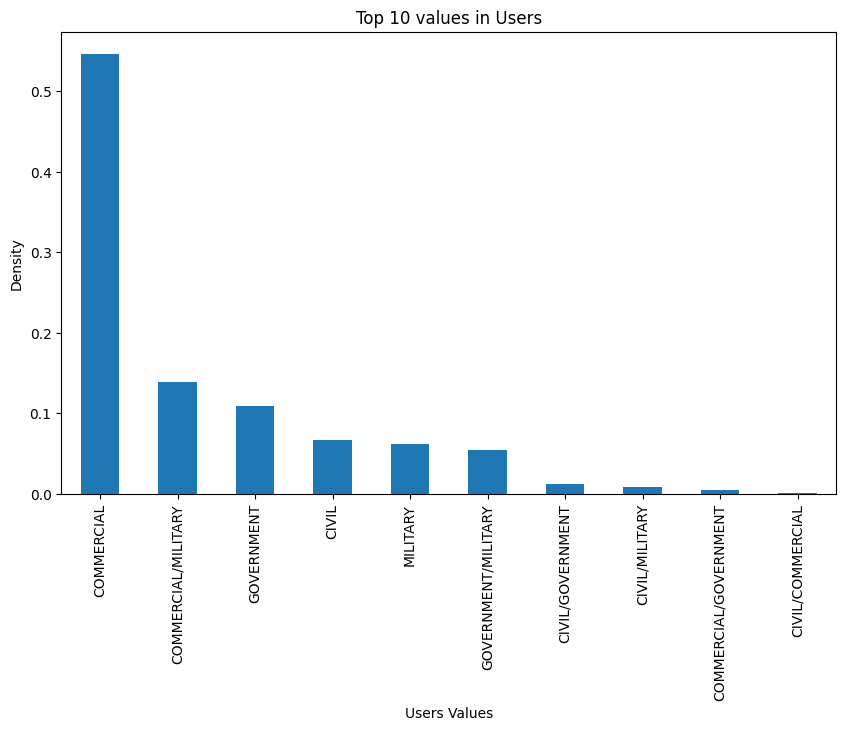

Column: Purpose
Type: object
Found 4 unique values


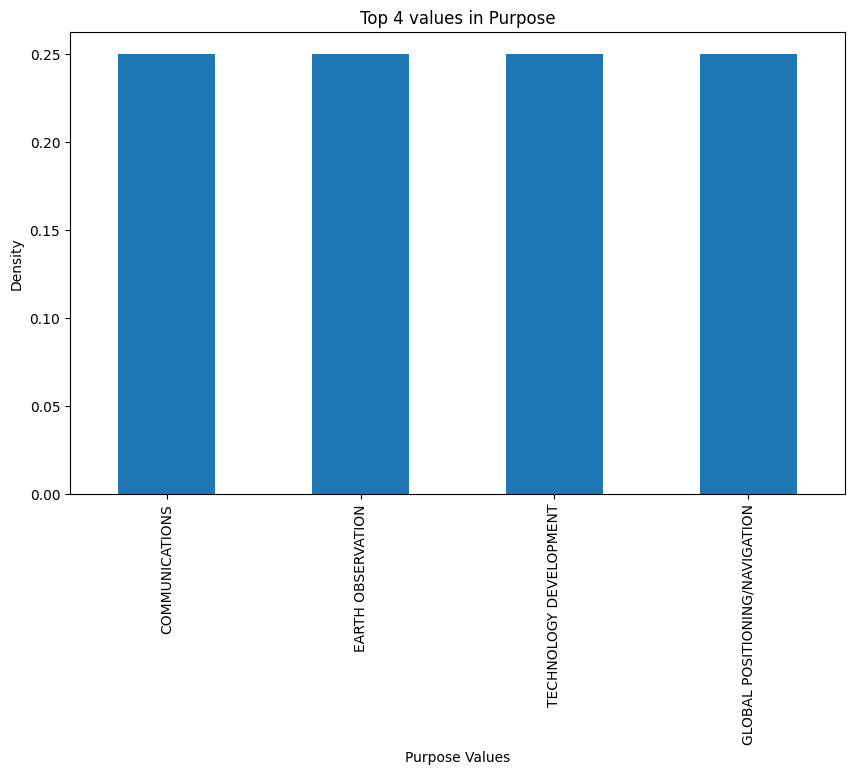

Column: Type of Orbit
Type: object
Found 5 unique values


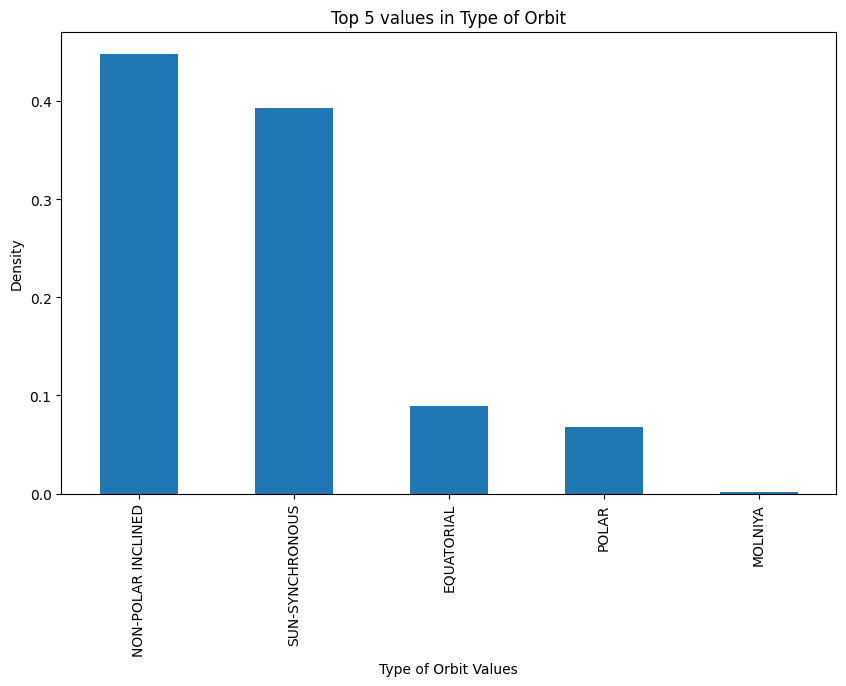

Column: Longitude of GEO (degrees)
Type: float64
Found 80 unique values


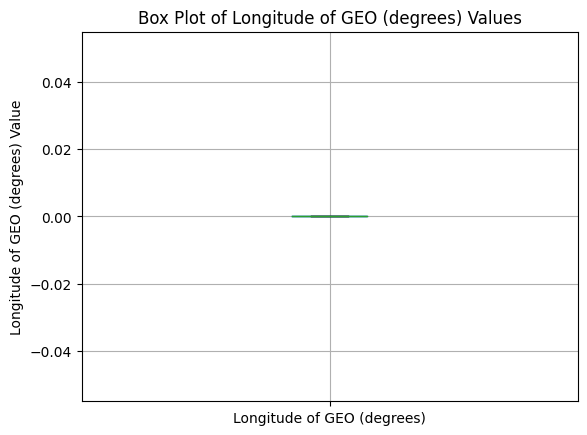

Column: Perigee (km)
Type: float64
Found 406 unique values


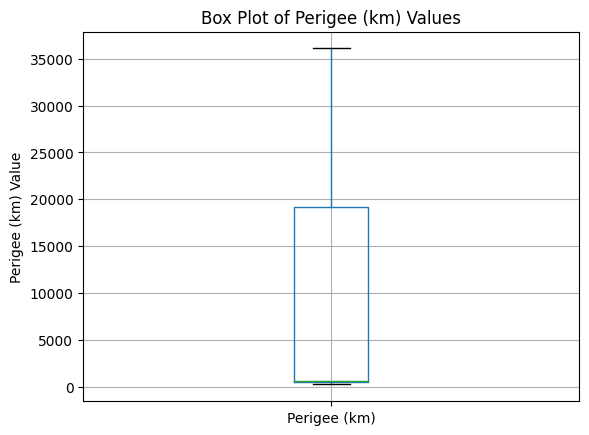

Column: Apogee (km)
Type: float64
Found 409 unique values


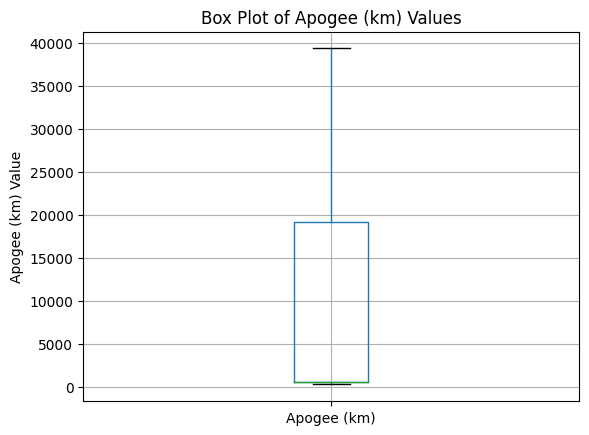

Column: Eccentricity
Type: float64
Found 726 unique values


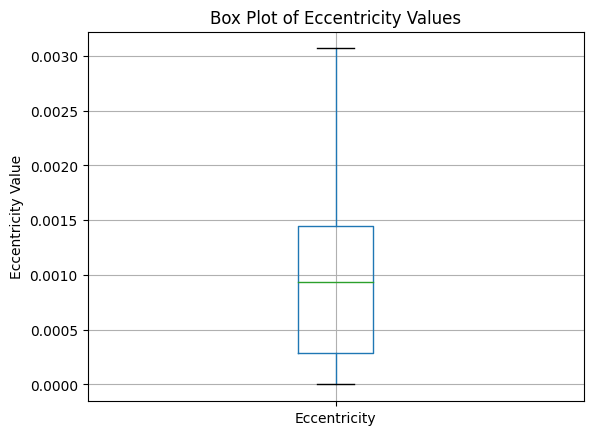

Column: Inclination (degrees)
Type: float64
Found 197 unique values


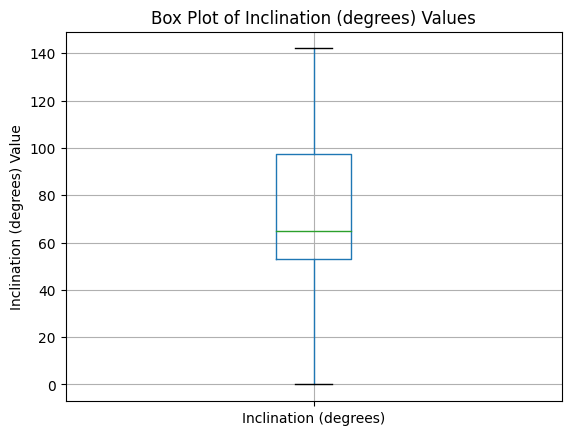

Column: Period (minutes)
Type: float64
Found 300 unique values


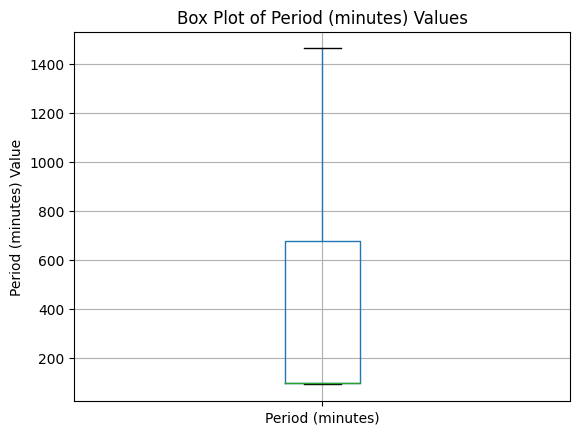

Column: Launch Mass (kg.)
Type: float64
Found 240 unique values


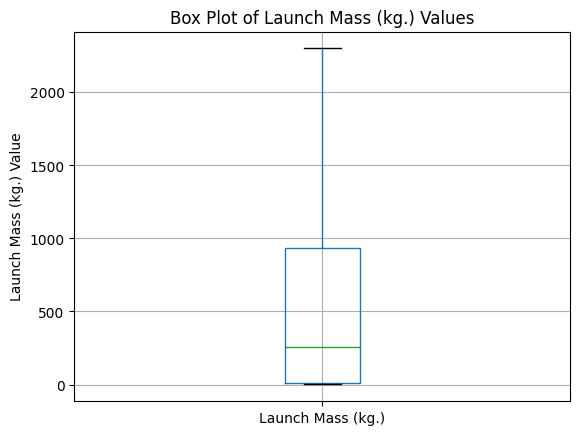

Column: Launch Site
Type: object
Found 35 unique values


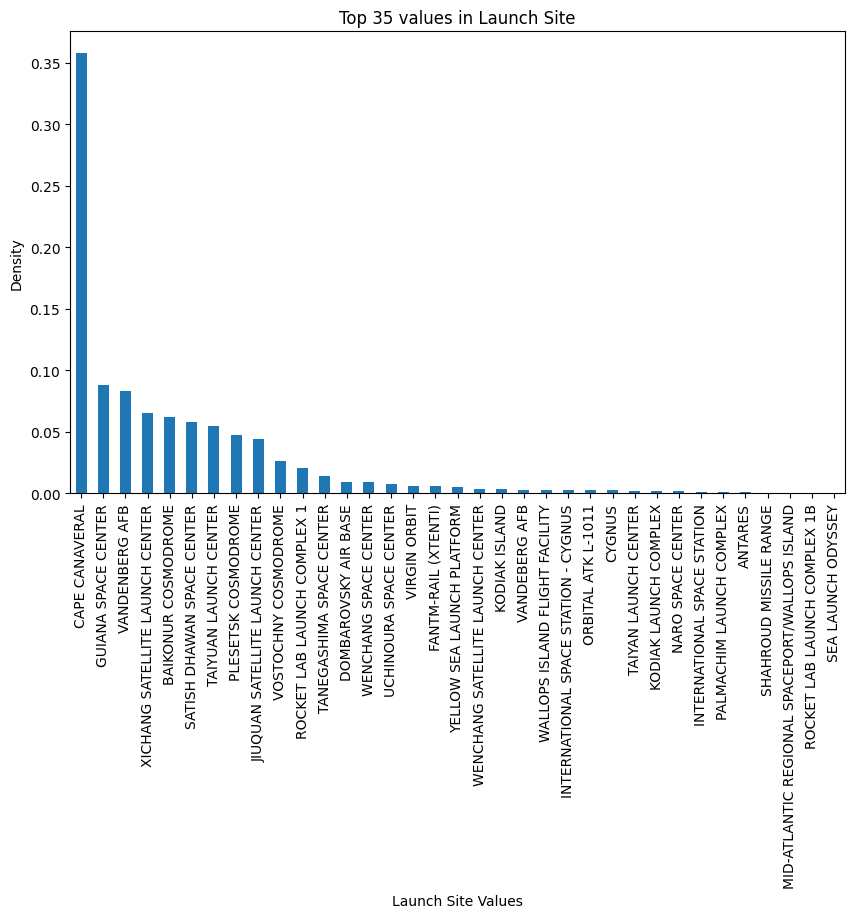

Column: Launch Vehicle
Type: object
Found 96 unique values


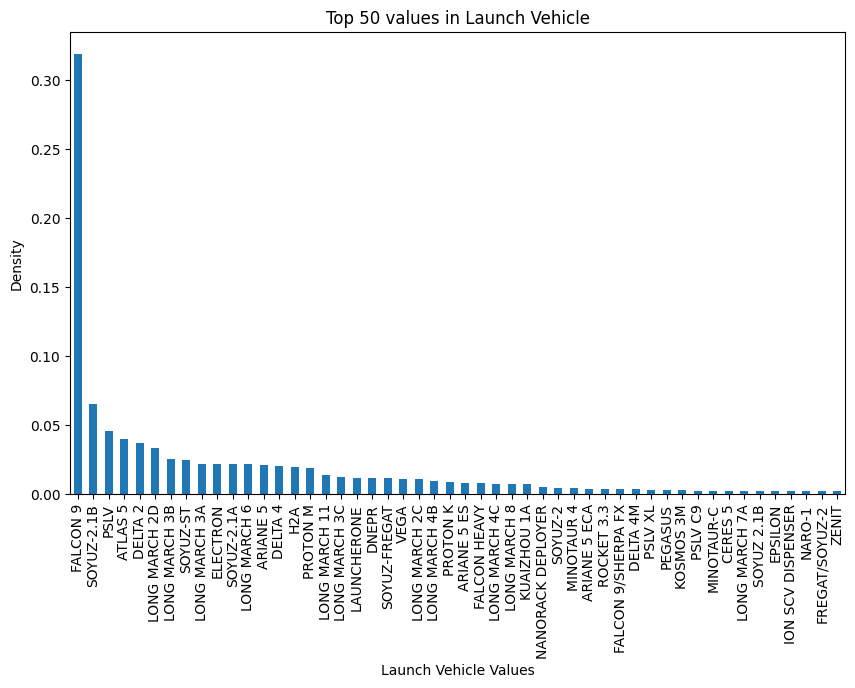

Column: Date of Launch
Type: datetime64[ns]
Found 507 unique values


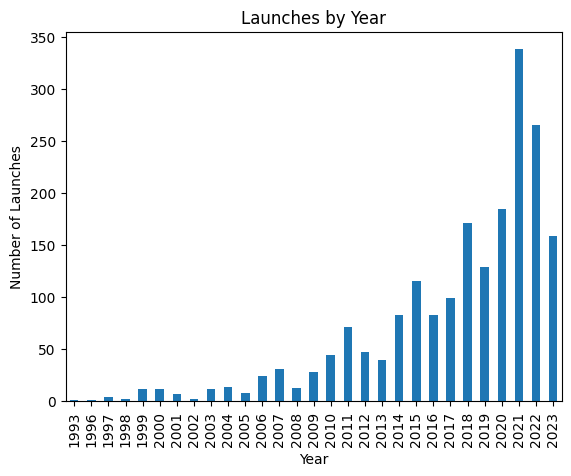

Column: Purpose_subset
Type: object
Found 4 unique values


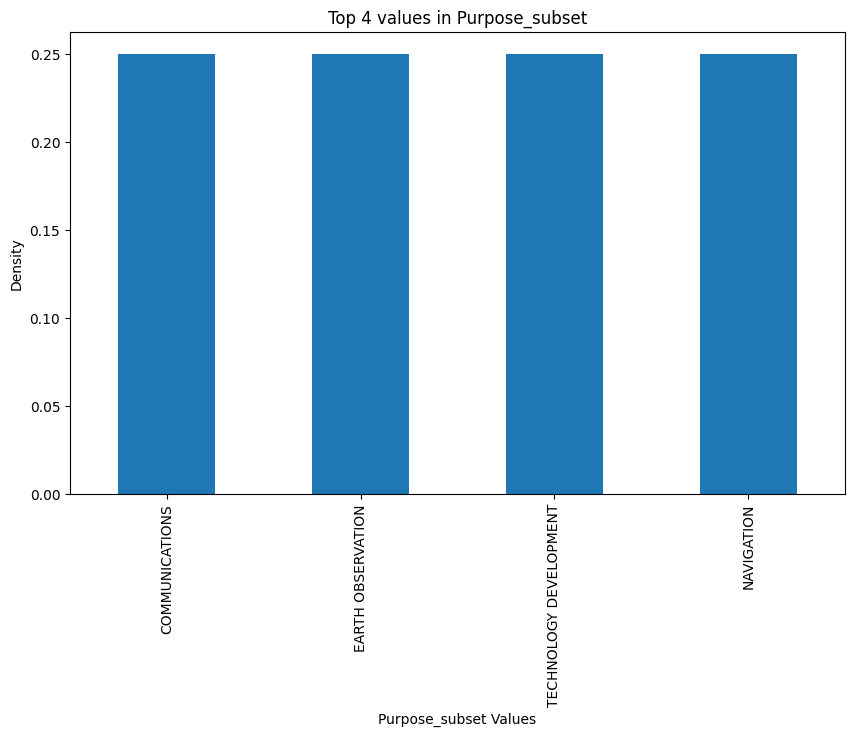

In [10]:
for column in balanced_data.columns:
  column_overview(balanced_data, column, show_plot=True)

## Data Preparation
While the data has been cleaned already, we need to prepare the data to enter the models we'll be developing. In general, models don't work well with text based data unless you are creating an NLP model, so in this section we'll be creating label encodings for the text-based attributes we have to work with.


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_mappings = {} # Used to keep track of mappings in case we need them later
categorical_feats = []
for col in sat_df.columns:
    if sat_df[col].dtype == 'object':
        sat_df[f'{col}_encoded'] = le.fit_transform(sat_df[col])
        sat_df[col] = pd.Categorical(sat_df[col])
        balanced_data[f'{col}_encoded'] = le.fit_transform(balanced_data[col])
        balanced_data[col] = pd.Categorical(balanced_data[col])
        class_mapping = {index: label for index, label in enumerate(le.classes_)}
        encoded_mappings[col] = class_mapping
        categorical_feats.append(col)

# Model Building

In this section we will build two types of unsupervised models: K-means and DBSCAN classifiers. The goal is to see if we can reliably classify Satellite use based on some factors to be determined.


TODO: CLARIFY - First we'll perform preliminary feature selection based on a combination of correlation + iterating through feature choices to see which produce highest accuracy. After we'll build our models and apply different methods to try and negate biases in our data.


In [12]:
# During model building we'll track model performance with the results df
results = pd.DataFrame(columns=['Model', 'Balanced', 'Features', 'Accuracy'])

def add_to_results(model: str,balanced: bool, features: list, accuracy: float):
  global results
  new_row = { 'Model': model, 'Balanced': balanced, 'Features': features, 'Accuracy':accuracy}
  results.loc[len(results)] = new_row

In [13]:
real_labels = sat_df['Purpose'].unique()

## K-Means

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

def label_permute_compare(ytdf, yp, n):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    best_accuracy = 0
    best_map = None
    best_label = None

    # Generate permutations on the fly
    for perm in itertools.permutations(range(n)):
      # Map permutation to real label values
      label_map = {perm[i]: label for i, label in enumerate(real_labels)}
      # Map yp to use permuted labels
      yp_new = [label_map[value] for value in yp]
      accuracy = accuracy_score(ytdf, yp_new)
      # Update if accuracy is better
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_label = perm
        best_map = label_map

    return best_label, label_map, best_accuracy

def build_and_evaluate_kmeans(df, features, k, y_true, balanced_data: bool = False, show_matrix:bool = False):
  # Create a KMeans object with the number of clusters you want
  kmeans = KMeans(n_clusters=k, n_init=10, random_state=55)
  # Fit the KMeans model to your data
  data = df[features]
  # print(data.head())
  kmeans.fit(data)

  y_pred = kmeans.labels_

  best_label, label_map, best_accuracy = label_permute_compare(y_true,y_pred, n=k)

  if show_matrix:
    conf_matrix = confusion_matrix(y_true, y_pred)

  add_to_results(balanced=balanced_data, features = list(data.columns), accuracy = best_accuracy, model='KMEANS')

## Model One: Original Data - iterate through models

Now that we've picked our model features, lets evaluate the model.


In [15]:
# KMEANS DOESN"T ALLOW CATEGORICAL - drop those and target columns for input
import numpy as np
numerical_columns = sat_df.select_dtypes(include=[np.number]).columns
sat_df_numeric = sat_df[numerical_columns]
k = len(sat_df['Purpose'].unique())

# Choose top features
corr = sat_df_numeric.corr()
top_features = corr['Purpose_encoded'].sort_values(ascending=False)[2:7]
print(top_features)
top_features = top_features.index.tolist()

sat_df_numeric = sat_df_numeric.drop(['Purpose_encoded', 'Purpose_subset_encoded'], axis=1)

Type of Orbit_encoded     0.409407
Inclination (degrees)     0.325541
Users_encoded             0.225085
Launch Site_encoded       0.223314
Launch Vehicle_encoded    0.178805
Name: Purpose_encoded, dtype: float64


In [16]:
from itertools import combinations

# Iterate on Features
n = len(top_features)+1
feature_combos = [list(feature_combo) for r in range(1, n) for feature_combo in combinations(top_features, r)]
print(f"Testing {len(feature_combos)} feature combinations.")
for features in feature_combos:
  build_and_evaluate_kmeans(
      df = sat_df_numeric,
      features = features,
      k=k,
      balanced_data = False,
      y_true = sat_df['Purpose'],
  )

Testing 31 feature combinations.


In [17]:
results.sort_values(by='Accuracy', ascending=False).head()


,Model,Balanced,Features,Accuracy
2,KMEANS,False,[Users_encoded],0.811378
6,KMEANS,False,"[Type of Orbit_encoded, Users_encoded]",0.809223
4,KMEANS,False,[Launch Vehicle_encoded],0.701480
8,KMEANS,False,"[Type of Orbit_encoded, Launch Vehicle_encoded]",0.701480
19,KMEANS,False,"[Type of Orbit_encoded, Users_encoded, Launch ...",0.701480


## Model Two: Balanced Data - iterate through models


In [18]:
numerical_columns = balanced_data.select_dtypes(include=[np.number]).columns
balanced_data_numeric = balanced_data[numerical_columns]

# Choose top features
corr = balanced_data_numeric.corr()
top_features = corr['Purpose_encoded'].sort_values(ascending=False)[2:7]
print(top_features)
top_features = top_features.index.tolist()

balanced_data_numeric = balanced_data_numeric.drop(['Purpose_encoded', 'Purpose_subset_encoded'], axis=1)

Launch Site_encoded      0.214153
Inclination (degrees)    0.203664
Type of Orbit_encoded    0.169911
Apogee (km)              0.151013
Perigee (km)             0.148909
Name: Purpose_encoded, dtype: float64


In [19]:
n = len(top_features)+1
feature_combos = [list(feature_combo) for r in range(1, n) for feature_combo in combinations(top_features, r)]
print(f"Testing {len(feature_combos)} feature combinations.")
for features in feature_combos:
  build_and_evaluate_kmeans(
      df = balanced_data_numeric,
      features = features,
      k=k,
      balanced_data = True,
      y_true = balanced_data['Purpose'],
  )

Testing 31 feature combinations.


# DBSCAN

In [20]:
from sklearn.cluster import DBSCAN


def build_and_evaluate_dbscan(
    df,
    features,
    y_true,
    eps: float,
    min_samples:int,
    clusters:int,
    shift:int ,
    balanced_data: bool = False,
    show_matrix:bool = False
):
  data = df[features]
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  y_pred = dbscan.fit_predict(data)
  # shift so that y_pred values are on same scale as expected [0-3]
  y_shift = y_pred + shift
  # print(np.unique(y_shift))
  best_label, label_map, best_accuracy = label_permute_compare(y_true,y_shift, n=k)

  if show_matrix:
    conf_matrix = confusion_matrix(y_true, y_pred)

  add_to_results(balanced=balanced_data, features = list(data.columns), accuracy = best_accuracy, model='DBSCAN')

  return y_pred



## Model One: Original Data - iterate through models

In [21]:
n = len(top_features)+1

feature_combos = [list(feature_combo) for r in range(1, n) for feature_combo in combinations(top_features, r)]
print(f"Testing {len(feature_combos)} feature combinations.")

for i, features in enumerate(feature_combos):
  pred = build_and_evaluate_dbscan(
      df = sat_df_numeric,
      features = features,
      y_true = sat_df['Purpose'],
      eps = 0.65,
      min_samples = 600,
      clusters = k,
      shift=1 ,
      balanced_data = False,
  )

Testing 31 feature combinations.


## Model Two: Balanced Data - iterate through models


In [22]:
n = len(top_features)+1
feature_combos = [list(feature_combo) for r in range(1, n) for feature_combo in combinations(top_features, r)]
print(f"Testing {len(feature_combos)} feature combinations.")

for i, features in enumerate(feature_combos):
  pred = build_and_evaluate_dbscan(
      df = balanced_data_numeric,
      features = features,
      y_true = balanced_data['Purpose'],
      eps = 0.75,
      min_samples = 150,
      clusters = k,
      shift=1,
      balanced_data = True,
  )

Testing 31 feature combinations.


# Step Four: Results and Analysis

In [23]:
results_sorted = results.sort_values(by='Accuracy', ascending=False)
best_accuracies = results_sorted.groupby(['Model', 'Balanced']).head(1)
print("Best Accuracy by Model")
best_accuracies.head()


Best Accuracy by Model


,Model,Balanced,Features,Accuracy
2,KMEANS,False,[Users_encoded],0.811378
86,DBSCAN,False,"[Type of Orbit_encoded, Apogee (km), Perigee (...",0.685965
94,DBSCAN,True,[Inclination (degrees)],0.567000
61,KMEANS,True,"[Launch Site_encoded, Inclination (degrees), T...",0.469500


In [24]:
results_sorted = results.sort_values(by='Accuracy', ascending=False)
print("Top Overall Results")
results_sorted.head(10)

Top Overall Results


,Model,Balanced,Features,Accuracy
2,KMEANS,False,[Users_encoded],0.811378
6,KMEANS,False,"[Type of Orbit_encoded, Users_encoded]",0.809223
4,KMEANS,False,[Launch Vehicle_encoded],0.701480
13,KMEANS,False,"[Users_encoded, Launch Vehicle_encoded]",0.701480
8,KMEANS,False,"[Type of Orbit_encoded, Launch Vehicle_encoded]",0.701480
19,KMEANS,False,"[Type of Orbit_encoded, Users_encoded, Launch ...",0.701480
86,DBSCAN,False,"[Type of Orbit_encoded, Apogee (km), Perigee (...",0.685965
76,DBSCAN,False,"[Apogee (km), Perigee (km)]",0.685965
82,DBSCAN,False,"[Launch Site_encoded, Apogee (km), Perigee (km)]",0.685965
89,DBSCAN,False,"[Launch Site_encoded, Inclination (degrees), A...",0.685965


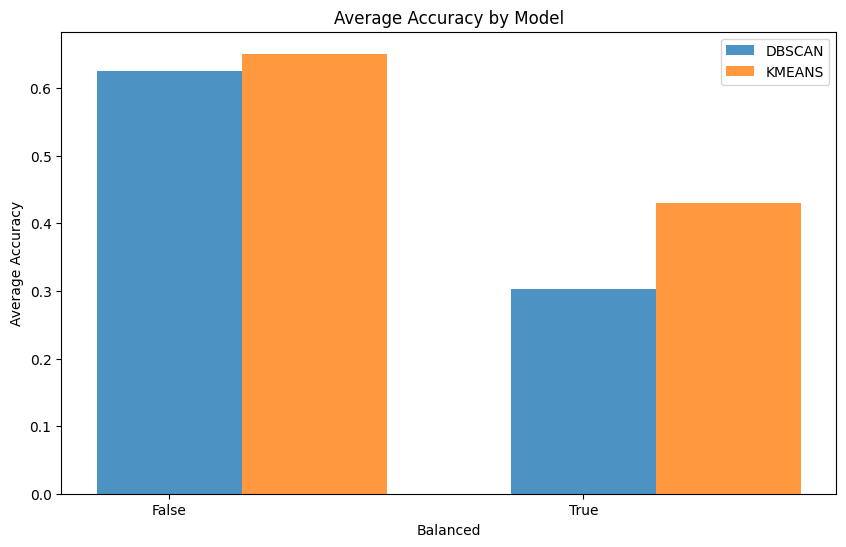

In [25]:
average_accuracy = results.groupby(['Model', 'Balanced'])['Accuracy'].mean().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of the bars
for i, (label, df_group) in enumerate(average_accuracy.groupby('Model')):
    x = df_group['Balanced'].astype(str).astype('category').cat.codes
    plt.bar(x + i * bar_width, df_group['Accuracy'], width=bar_width, label=label, alpha =0.8)

plt.xlabel('Balanced')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy by Model')
plt.xticks([0, 1], ['False', 'True'])
plt.legend()
plt.show()


TODO: Complete this section

# Step Five: Conclusions

TODO: Complete this section